# Mask R-CNN - Inspect Guidewire_point Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNNl
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images

from mrcnn.model_point import log


%matplotlib inline 

# Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, "logs_point",)
MODEL_DIR = '/home/li/Mask_RCNN_point/logs_point_test/res50_FF_hour256_1_0.0005_b2_mask/guidewire20210430T0946/'
sys.path.append(MODEL_DIR)
import guidewire_config as guidewire
import model as modellib
# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
# WEIGHTS_PATH = "/home/li/Mask_RCNN_point/logs_point1/mobile_all_float_aug8/guidewire20200913T2224/mask_rcnn_guidewire_0100.h5"  # TODO: update this path

/home/li/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/li/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/li/anaconda3/envs/keras/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/li/anaconda3/envs/keras/lib/python3.6/site-packages/ten

## Configurations

In [2]:
config = guidewire.GuidewireConfig()
guidewire_DIR = '/home/li/GuideWire/guidewire_2020'

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
BRANCH                         hour
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        5
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
DOUBLE                         False
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
INFERENCE_NUM                  200
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0005
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'class_loss': 1.0, 'bbox_l

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
# DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0
DEVICE = "/gpu:0"
# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"
# TEST_MODE = "training"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Load validation dataset
dataset = guidewire.GuidewireDataset()
dataset.load_guidewire(guidewire_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 1041
Classes: ['BG', 'guidewire']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode=TEST_MODE, model_dir=MODEL_DIR,
                              config=config)

resnet50


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [8]:
# Set path to balloon weights file
def find_last1(dir_name):
        """Finds the last checkpoint file of the last trained model in the
        model directory.
        Returns:
            The path of the last checkpoint file
        """
        # Find the last checkpoint
        checkpoints = next(os.walk(dir_name))[2]
        checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
        checkpoints = sorted(checkpoints)
        if not checkpoints:
            import errno
            raise FileNotFoundError(
                errno.ENOENT, "Could not find weight files in {}".format(dir_name))
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        return checkpoint

# Or, load the last model you trained
weights_path = find_last1(MODEL_DIR)
# weights_path = "/home/li/Mask_RCNN_point/logs_point/guidewire20200416T0146/mask_rcnn_guidewire_0149.h5"
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/li/Mask_RCNN_point/logs_point_test/res50_FF_hour256_1_0.0005_b2_mask/guidewire20210430T0946/mask_rcnn_guidewire_0080.h5
Re-starting from epoch 80


## Run Detection

In [11]:
import keras.backend as K 
class MAPCallback():
    def _voc_ap(self, rec, prec):
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
        return ap


    def calculate_aps(self):
        true_res = {}
        pred_res = []
        idx = 0
        APs = {}
        inference_time = 0
        for i in range(self.inference_num):
            image, class_ids, bbox, point =modellib.load_image_gt1(self.val_dataset, i)
            start = time.time()
            results=self.model.detect([image])[0]
            end = time.time()
            inference_time = inference_time + (end - start)
            out_boxes= results['rois']
            out_scores = results['scores']
            out_masks = results['masks']
            if len(out_boxes) > 0:
                for out_box, out_score, out_mask in zip(
                        out_boxes, out_scores, out_masks):
                    det_point = np.unravel_index(out_mask[:,:,0].argmax(), out_mask[:,:,0].shape)
                    score = out_mask[det_point[0],det_point[1],0]
#                     pred_res.append([i, 0, out_score*score, det_point[1], det_point[0]])
                    pred_res.append([i, 0, out_score, det_point[1], det_point[0]])
                    det_point = np.unravel_index(out_mask[:,:,1].argmax(), out_mask[:,:,1].shape)
                    score = out_mask[det_point[0],det_point[1],1]
#                     pred_res.append([i, 1, out_score*score, det_point[1], det_point[0]])
                    pred_res.append([i, 1, out_score, det_point[1], det_point[0]])

            true_res[i] = point  #[num_guidewire, num_point, 2]
            idx += 1
        
        print('avg_infer_time:'+str(inference_time / self.inference_num))
        for cls in range(self.num_classes):
            pred_res_cls = [x for x in pred_res if x[1] == cls]
            if len(pred_res_cls) == 0:
                APs[cls] = 0
                continue
            true_res_cls = {}
            npos = 0
            for index in true_res: #index is the image_id
                guidewires = true_res[index] #[num_guidewire, num_point, 2]
                npos += len(guidewires)  #compute recall
                point_pos = np.array([x[cls] for x in guidewires]) #[num_guidewire, 2]
                true_res_cls[index] = {
                    'point_pos': point_pos,
                }
            ids = [x[0] for x in pred_res_cls]
            scores = np.array([x[2] for x in pred_res_cls])
            points = np.array([x[3:] for x in pred_res_cls])
            sorted_ind = np.argsort(-scores)
            points = points[sorted_ind, :] #sorted
            ids = [ids[x] for x in sorted_ind] #sorted

            nd = len(ids)
            tp = np.zeros(nd)
            fp = np.zeros(nd)
            for j in range(nd):
                ture_point = true_res_cls[ids[j]]
                point1 = points[j, :]  #[2]
                dis_min = np.inf
                PGT = ture_point['point_pos'] #[num_guidewire, 2]
                if len(PGT) > 0:
                    dis_square= np.square(PGT[:,0]-point1[0])+ np.square(PGT[:,1]-point1[1])
                    dis_min = np.min(dis_square)
                if dis_min<self.threshold*self.threshold:
                    tp[j] = 1.
                else:
                    fp[j] = 1.

            fp = np.cumsum(fp)
            tp = np.cumsum(tp)
            rec = tp / np.maximum(float(npos), np.finfo(np.float64).eps)
            prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
            ap = self._voc_ap(rec, prec)
            APs[cls] = ap
        return APs

    def __init__(self,
                 model,
                 val_dataset,
                 class_names,
                 threshold=5,
                 inference_num =50,
                 batch_size=1):
        super(MAPCallback, self).__init__()
        self.model=model
        self.inference_num = inference_num
        self.class_names = class_names
        self.num_classes = len(class_names)
        self.val_dataset = val_dataset
        self.threshold = threshold
        self.batch_size = batch_size

    def on_epoch_end(self, logs=None):
        logs = logs or {}
        origin_learning_phase = tf.keras.backend.learning_phase()
#         K.set_learning_phase(0)
        APs = self.calculate_aps()
#         K.set_learning_phase(origin_learning_phase)
        for cls in range(self.num_classes):
            if cls in APs:
                print(self.class_names[cls] + ' ap: ', APs[cls])
        mAP = np.mean([APs[cls] for cls in APs])
        print('mAP: ', mAP)
        logs['mAP'] = mAP
        

In [12]:
MAP=MAPCallback(model, dataset,['tip','back'],threshold=7,inference_num =1040)
MAP.on_epoch_end()


avg_infer_time:0.13895570887969091
tip ap:  0.5138109182091388
back ap:  0.5635705426483755
mAP:  0.5386907304287571


822
image ID: guidewire.89843418_13.jpg (822) /home/li/GuideWire/guidewire_2020/val/89843418_13.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
0.1775965690612793


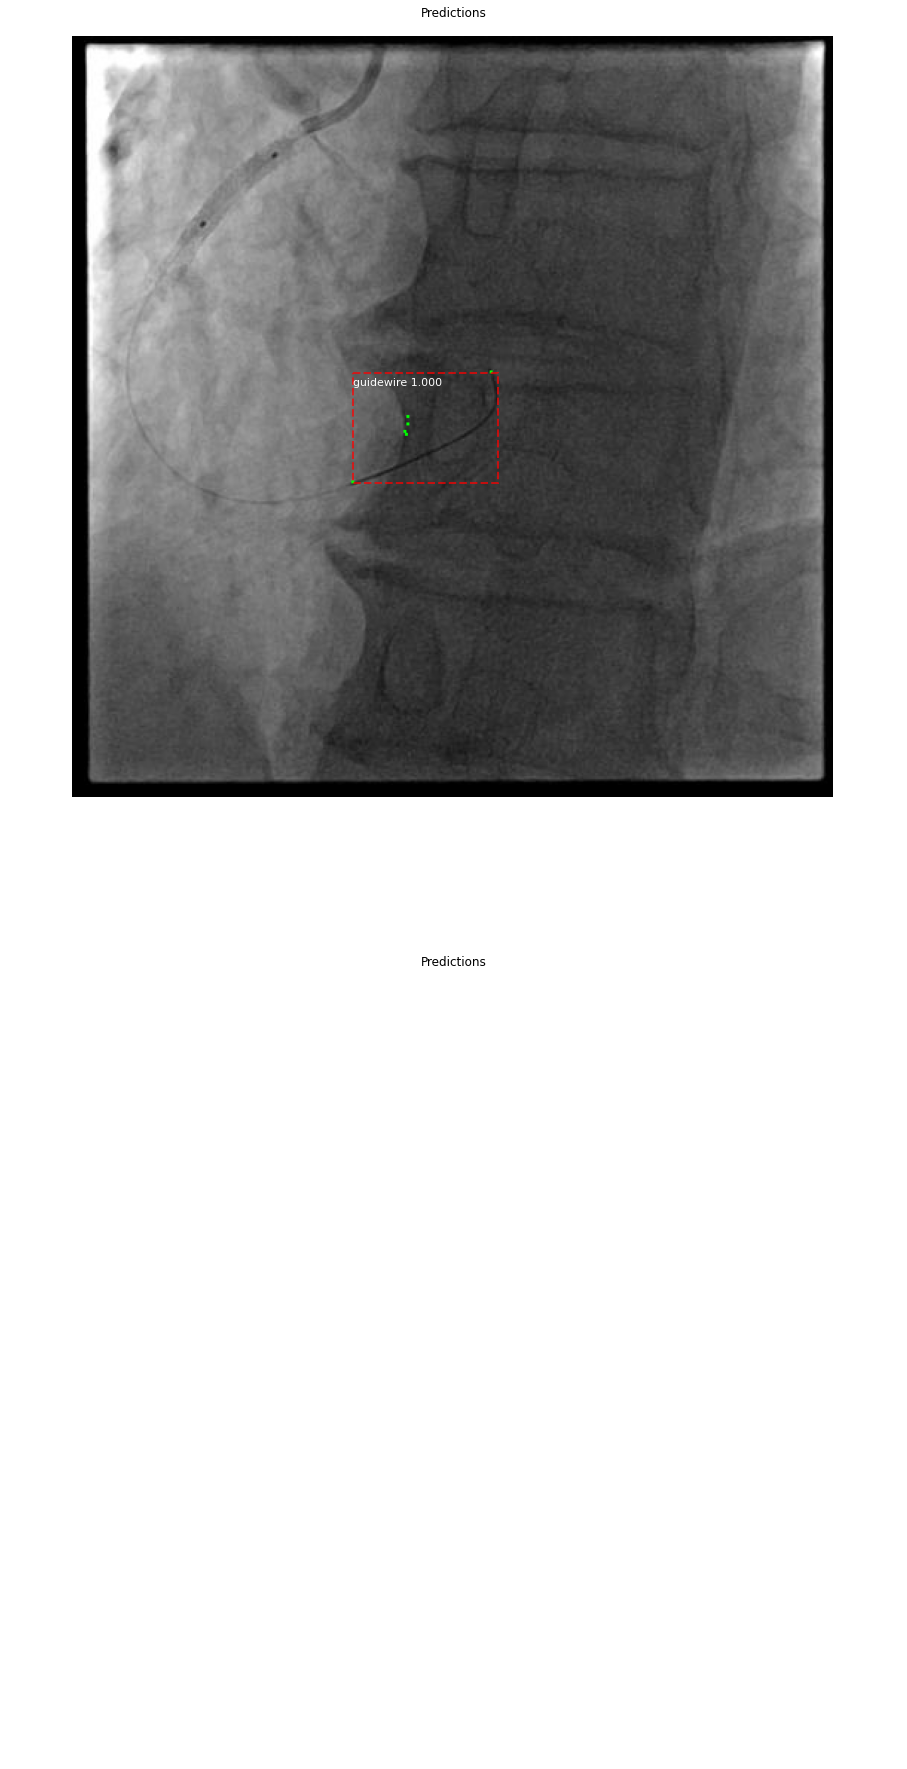

[[224 186 303 287]]
[[[281 224]
  [187 302]]]
[[226 188 300 286]]


In [35]:
image_id = random.choice(dataset.image_ids)
# image_id = 3
# 273
# image_id =3
print(image_id)
import time

image, gt_class_id, gt_bbox, point =\
    modellib.load_image_gt_eval(dataset, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
s=time.time()
results = model.detect([image], verbose=1)
e=time.time()
print(e-s)
# Display results
ax = get_ax(2,1)
r = results[0]
visualize.display_point_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
print(gt_bbox)
print(point)
print(r['rois'])


In [10]:
import mrcnn.compute_metrics as metrics
joint_acc = np.zeros([2])
num_object = 0
inference_time = 0
for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, point =\
        modellib.load_image_gt(dataset, config, image_id)
    print(image_id)
#     info = dataset.image_info[image_id]
#     print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
#                                            dataset.image_reference(image_id)))
#     print(gt_bbox.shape)
    s=time.time()
    results = model.detect([image], verbose=0) #only the value above threshold will be counted
    e=time.time()
    inference_time=inference_time+e-s
    r = results[0] #only one image
    det_boxes=r['rois']
    det_masks=r['masks']
    det_class_ids=r['class_ids']
    joint_acc1, num1 = metrics._compute_pre(det_masks, point, det_boxes, gt_bbox, 7)

    joint_acc += joint_acc1
    num_object += num1
    print(joint_acc, num_object)
print('inference_time: ', inference_time/num_object)

0
[0.71590195]
[1. 1.] 1
1
[0.82639334]
[2. 2.] 2
2
[0.76]
[3. 3.] 3
3
[0.82306388]
[4. 4.] 4
4
[0.79145729]
[4. 5.] 5
5
[0.94330634]
[5. 6.] 6
6
[0.85768176]
[6. 7.] 7
7
[0.93701997]
[7. 8.] 8
8
[0.62277814]
[7. 9.] 9
9
[0.81696429]
[ 8. 10.] 10
10
[0.72592593]
[ 9. 11.] 11
11
[0.92231232]
[10. 12.] 12
12
[0.84781114]
[11. 13.] 13
13
[0.79278642]
[12. 14.] 14
14
[0.60091241]
[13. 14.] 15
15
[0.89231341]
[14. 15.] 16
16
[0.95888088]
[15. 16.] 17
17
[0.94239069]
[16. 17.] 18
18
[0.89651884]
[17. 17.] 19
19
[0.8748538]
[18. 18.] 20
20
[0.94086022]
[19. 19.] 21
21
[0.75265554]
[19. 20.] 22
22
[0.92121212]
[20. 21.] 23
23
[0.78079332]
[20. 22.] 24
24
[0.7993944]
[20. 23.] 25
25
[0.95996681]
[21. 24.] 26
26
[0.92720764]
[22. 24.] 27
27
[0.86153846]
[22. 25.] 28
28
[0.90771558]
[22. 25.] 29
29
[0.89739222]
[23. 26.] 30
30
[0.89536785]
[24. 27.] 31
31
[0.8032057]
[25. 28.] 32
32
[0.97368421]
[26. 29.] 33
33
[0.72269457]
[26. 30.] 34
34
[0.82651891]
[27. 31.] 35
35
[0.964757]
[28. 32.] 36
36
[

254
[0.89323098]
[223. 248.] 263
255
[0.78947368]
[224. 249.] 264
256
[0.90507953 0.        ]
[0.         0.94583949]
[226. 251.] 266
257
[0.90505051]
[227. 252.] 267
258
[0.81495545]
[228. 253.] 268
259
[0.8858739]
[229. 254.] 269
260
[0.93019197]
[230. 254.] 270
261
[230. 254.] 271
262
[0.90493097]
[231. 255.] 272
263
[0.88988095]
[232. 256.] 273
264
[0.89439271]
[233. 257.] 274
265
[0.88784247]
[234. 258.] 275
266
[0.88709677]
[235. 259.] 276
267
[0.85655738]
[235. 260.] 277
268
[0.80375669]
[236. 261.] 278
269
[0.65636588]
[237. 262.] 279
270
[0.93633148]
[238. 263.] 280
271
[0.84140414]
[239. 264.] 281
272
[0.88448845]
[239. 265.] 282
273
[0.84522503]
[240. 266.] 283
274
[0.83099753]
[240. 267.] 284
275
[0.78816568]
[241. 268.] 285
276
[0.7770785]
[242. 269.] 286
277
[0.94672131]
[243. 270.] 287
278
[0.88366202]
[244. 271.] 288
279
[0.72395583]
[244. 272.] 289
280
[0.954323]
[245. 273.] 290
281
[0.93598926]
[246. 273.] 291
282
[0.8145528]
[247. 274.] 292
283
[0.84936479]
[248. 275

496
[0.85605381 0.        ]
[441. 482.] 512
497
[0.8539026]
[442. 483.] 513
498
[0.90897984]
[443. 484.] 514
499
[0.63343109]
[443. 484.] 515
500
[0.97055164]
[444. 485.] 516
501
[0.94627434]
[445. 486.] 517
502
[0.80275974]
[446. 487.] 518
503
[0.94469116]
[447. 488.] 519
504
[0.93498027]
[448. 489.] 520
505
[0.74800638]
[449. 490.] 521
506
[0.90343249]
[450. 491.] 522
507
[0.87622549]
[451. 492.] 523
508
[0.95702621]
[452. 493.] 524
509
[0.73863636]
[452. 493.] 525
510
[0.69043238]
[453. 494.] 526
511
[0.88743169]
[454. 495.] 527
512
[0.65166432]
[455. 496.] 528
513
[0.86585366]
[456. 497.] 529
514
[0.88012618]
[457. 498.] 530
515
[0.8380372]
[458. 499.] 531
516
[0.8999346]
[459. 500.] 532
517
[0.         0.92515396]
[0.92451749 0.        ]
[460. 502.] 534
518
[0.89269841]
[460. 502.] 535
519
[0.9587585]
[461. 503.] 536
520
[0.89058524]
[462. 504.] 537
521
[0.93647012]
[463. 505.] 538
522
[0.         0.77361564]
[0.80441989 0.        ]
[463. 507.] 540
523
[0.96411444]
[464. 508.] 541

[0.78552726]
[641. 710.] 759
735
[0.89115169]
[642. 711.] 760
736
[0.80239521]
[643. 712.] 761
737
[0.96363636]
[644. 713.] 762
738
[0.93444487]
[645. 714.] 763
739
[0.8672406]
[646. 715.] 764
740
[0.85900217]
[646. 716.] 765
741
[0.92307692]
[647. 717.] 766
742
[0.80405405]
[647. 717.] 767
743
[0.51102941]
[648. 718.] 768
744
[0.76996198 0.        ]
[649. 719.] 769
745
[0.78432602]
[650. 720.] 770
746
[0.90816871]
[651. 721.] 771
747
[0.93364559]
[652. 722.] 772
748
[0.96428571]
[653. 723.] 773
749
[0.97029703]
[654. 724.] 774
750
[0.82677165]
[655. 725.] 775
751
[0.79254079]
[656. 726.] 776
752
[0.89010989]
[657. 727.] 777
753
[0.46228448]
[657. 727.] 778
754
[0.84706919]
[658. 728.] 779
755
[0.87947494]
[659. 728.] 780
756
[0.90896359]
[660. 729.] 781
757
[0.88650101]
[661. 730.] 782
758
[0.88073394]
[662. 731.] 783
759
[0.92743363]
[663. 732.] 784
760
[0.7809052 0.       ]
[0.         0.89288984]
[665. 734.] 786
761
[0.87176471]
[666. 735.] 787
762
[0.75757576]
[666. 735.] 788
763


[0.7618198]
[853. 931.] 1008
978
[0.86956522]
[854. 932.] 1009
979
[0.90084493 0.        ]
[855. 933.] 1010
980
[0.82462203]
[855. 934.] 1011
981
[0.79502488 0.        ]
[0.         0.91230893]
[856. 936.] 1013
982
[0.85507702 0.        ]
[857. 937.] 1014
983
[0.89272388]
[858. 938.] 1015
984
[0.         0.75552748]
[0.76254783 0.        ]
[859. 940.] 1017
985
[0.87418655]
[860. 941.] 1018
986
[0.8203125]
[861. 942.] 1019
987
[0.77142857]
[862. 943.] 1020
988
[0.90054186]
[863. 944.] 1021
989
[0.90682696]
[864. 945.] 1022
990
[0.86639004]
[865. 946.] 1023
991
[0.72565056]
[865. 946.] 1024
992
[0.86720867]
[866. 947.] 1025
993
[0.93974066]
[867. 948.] 1026
994
[0.76026545]
[868. 949.] 1027
995
[0.67758007 0.        ]
[869. 950.] 1028
996
[0.77941176]
[870. 951.] 1029
997
[0.90403423]
[871. 952.] 1030
998
[0.90824448]
[872. 953.] 1031
999
[0.82403433]
[872. 953.] 1032
1000
[0.67447869]
[873. 954.] 1033
1001
[0.94086022]
[874. 955.] 1034
1002
[0.9410802]
[875. 956.] 1035
1003
[0.81546348]

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [28]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (65472,)              min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -1.65728  max:    2.25185  float64
positive_anchors         shape: (3, 4)                min:  260.68629  max:  438.62742  float64
negative_anchors         shape: (253, 4)              min: -181.01934  max:  526.62742  float64
neutral anchors          shape: (65216, 4)            min: -181.01934  max:  629.01934  float64
refined_anchors          shape: (3, 4)                min:  260.00000  max:  443.99997  float32


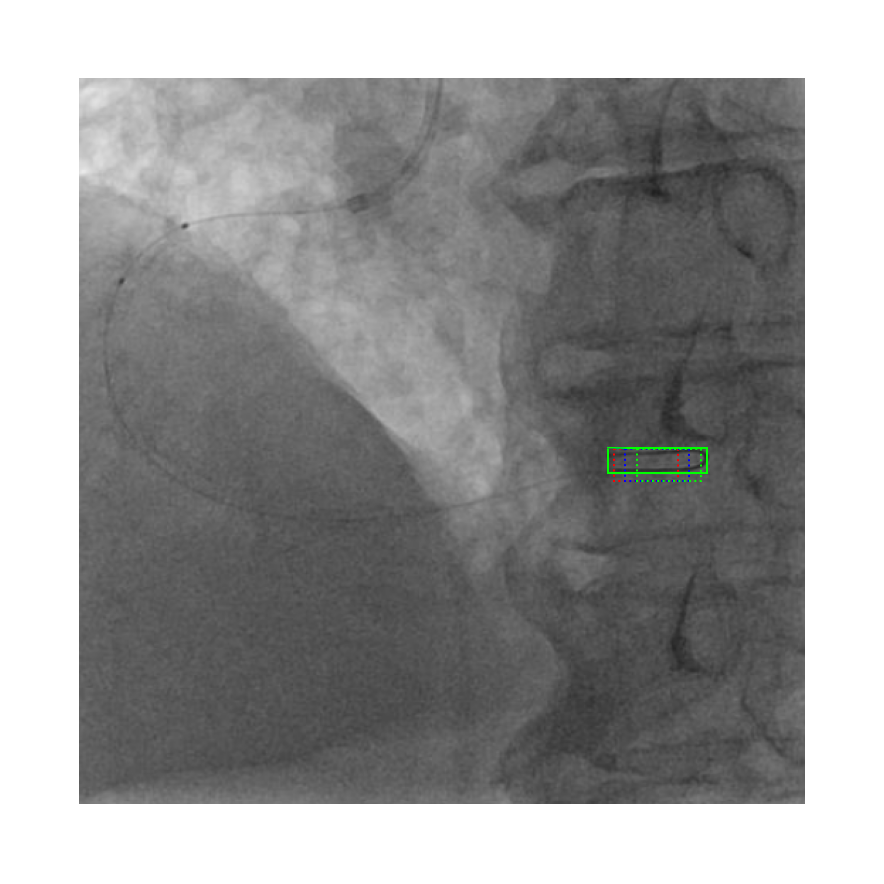

In [29]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [30]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 65472, 2)         min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35425  max:    1.22900  float32
refined_anchors          shape: (1, 6000, 4)          min:  -51.33577  max:   52.94047  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 1763.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


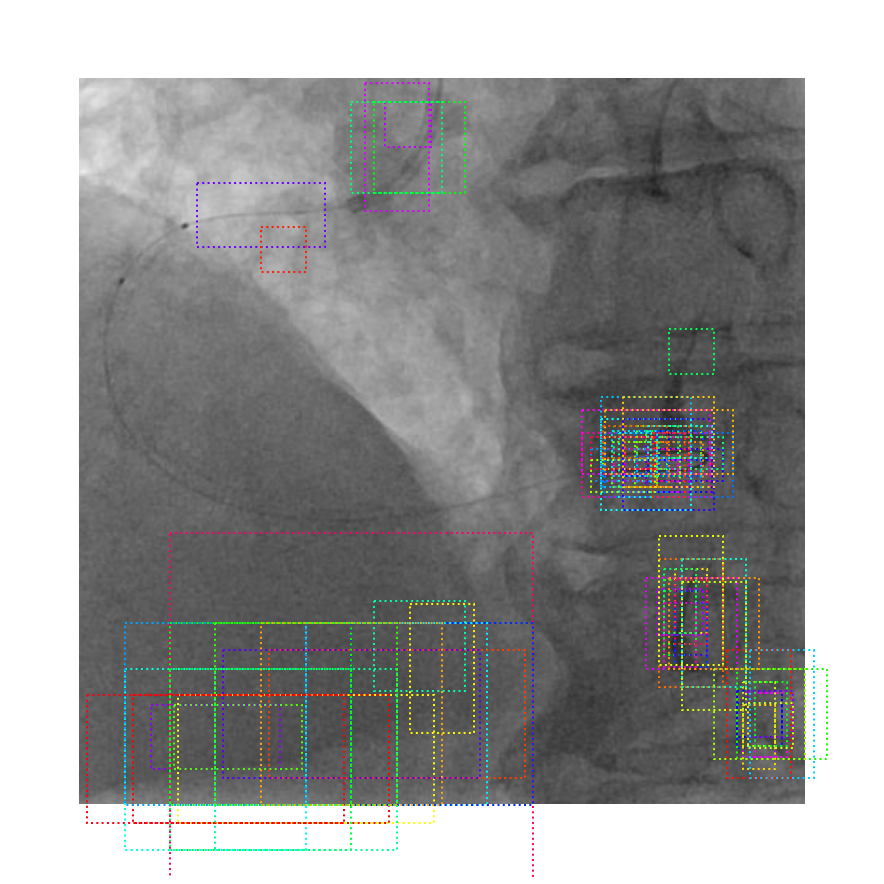

In [31]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

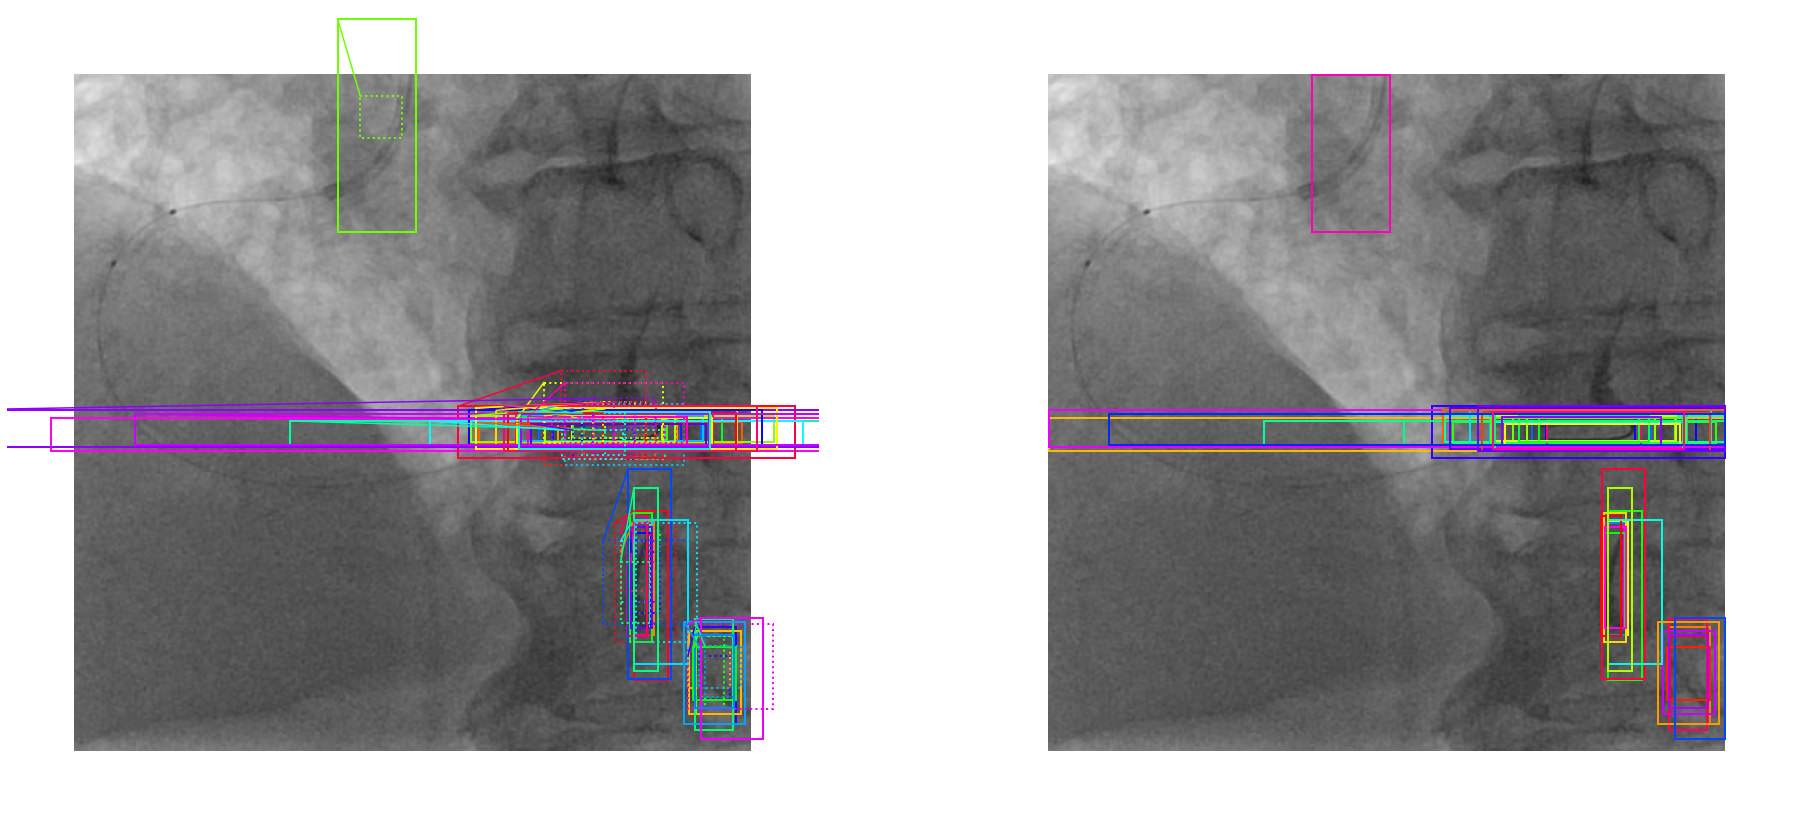

In [32]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

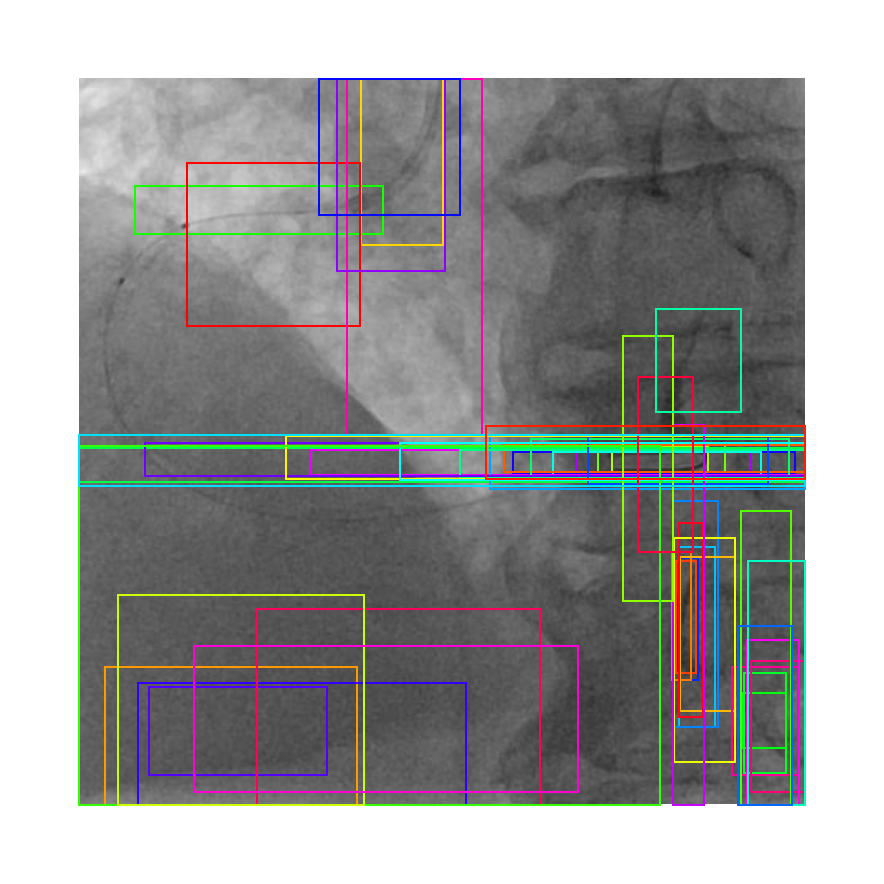

In [33]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

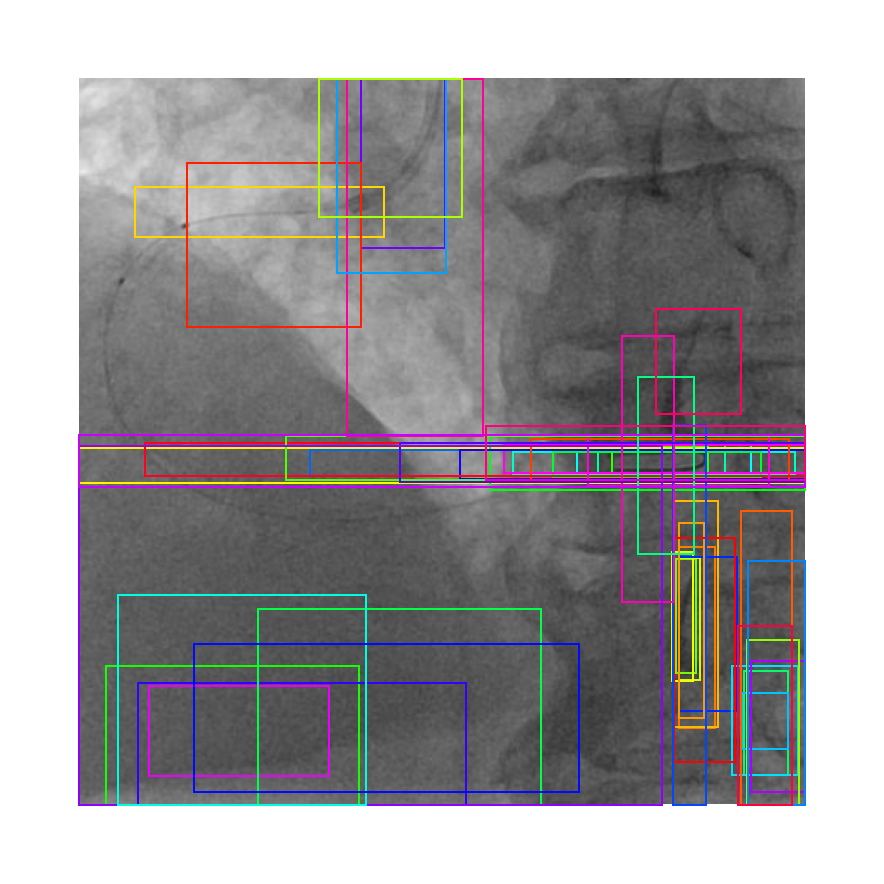

In [34]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [35]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -6.56903  max:    5.82360  float32
masks                    shape: (1, 5, 56, 56, 2)     min:    0.00000  max:    0.82084  float32
detections               shape: (1, 5, 6)             min:    0.00000  max:    1.00000  float32


1 detections: ['guidewire']


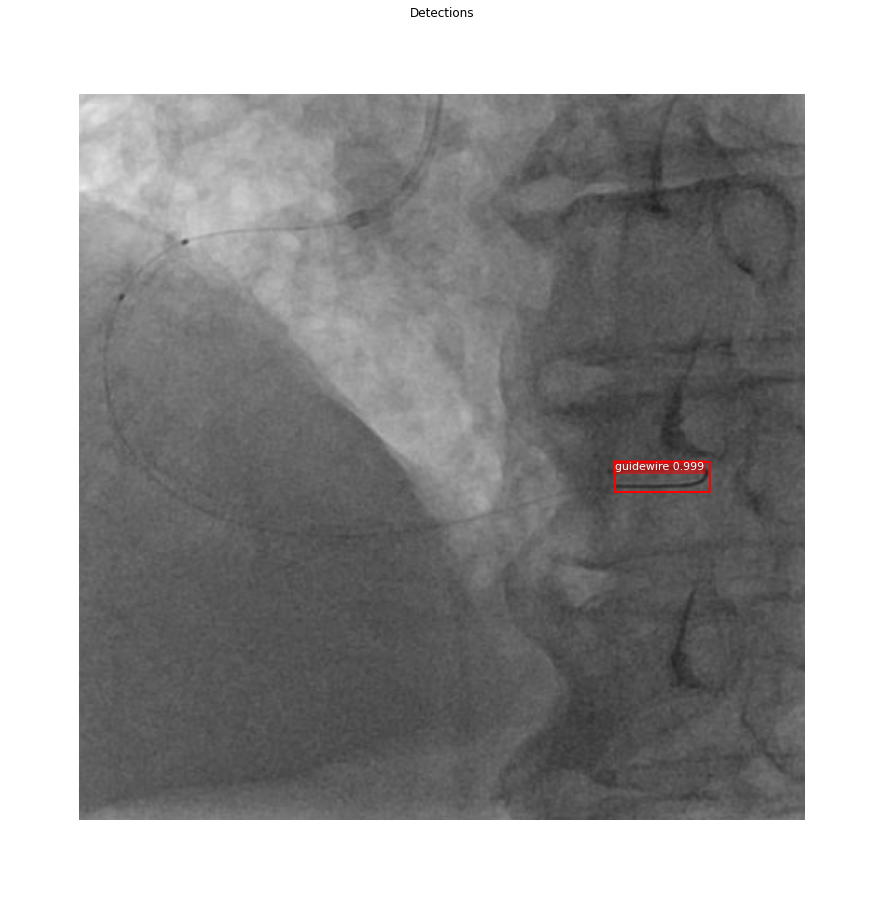

In [36]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [37]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
6 Positive ROIs
[('BG', 994), ('guidewire', 6)]


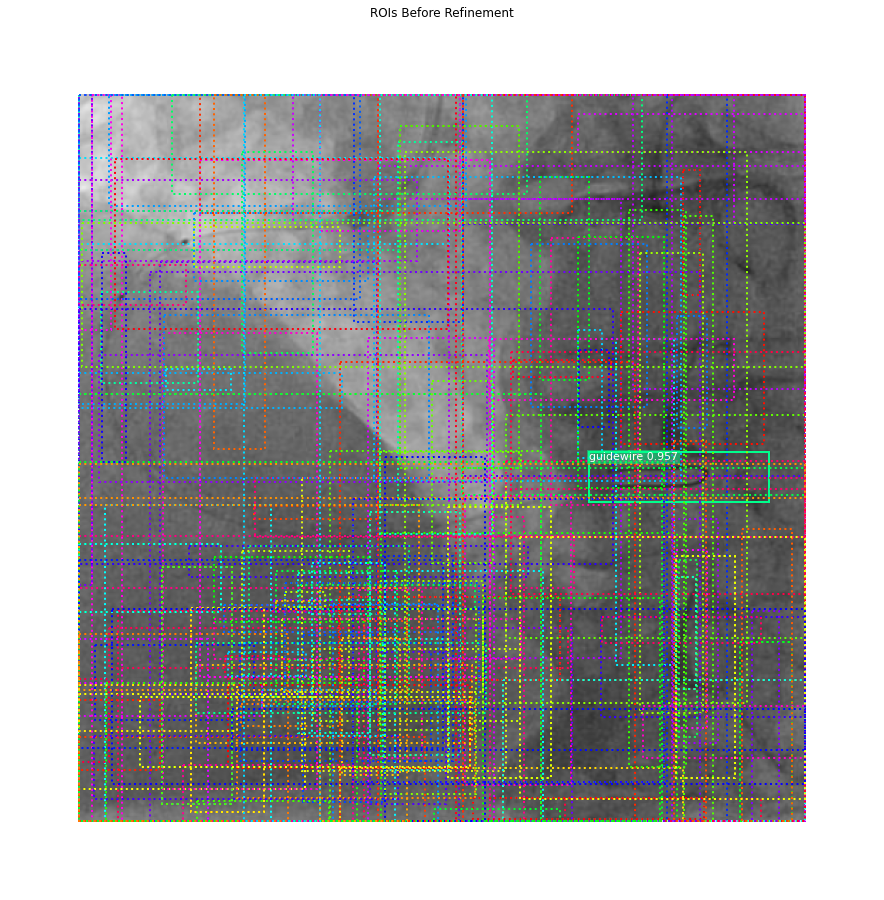

In [38]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

roi_bbox_specific        shape: (1000, 4)             min:   -5.04954  max:    5.82360  float32
refined_proposals        shape: (1000, 4)             min: -260.00000  max:  790.00000  int32


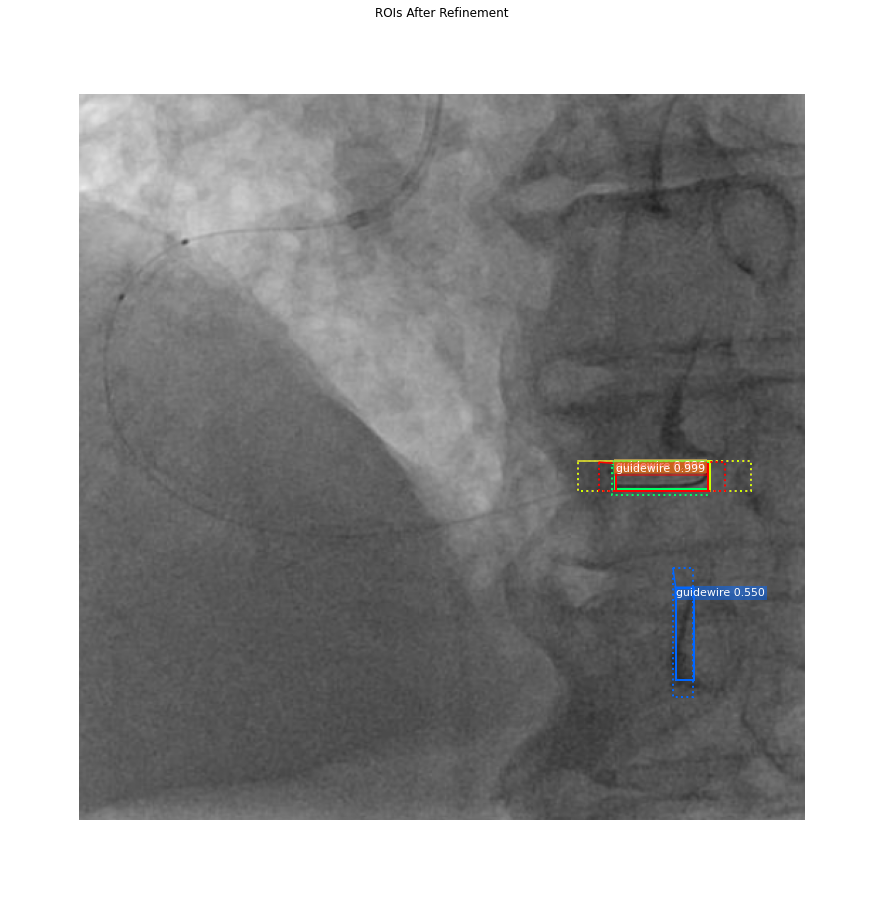

In [39]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [40]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 6 detections:
[ 0  1  2  5 11 24]


In [41]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 5:
[ 0  1  2  5 24]


#### Per-Class Non-Max Suppression

In [42]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

guidewire             : [ 0  1  2  5 24] -> [1]

Kept after per-class NMS: 1
[1]


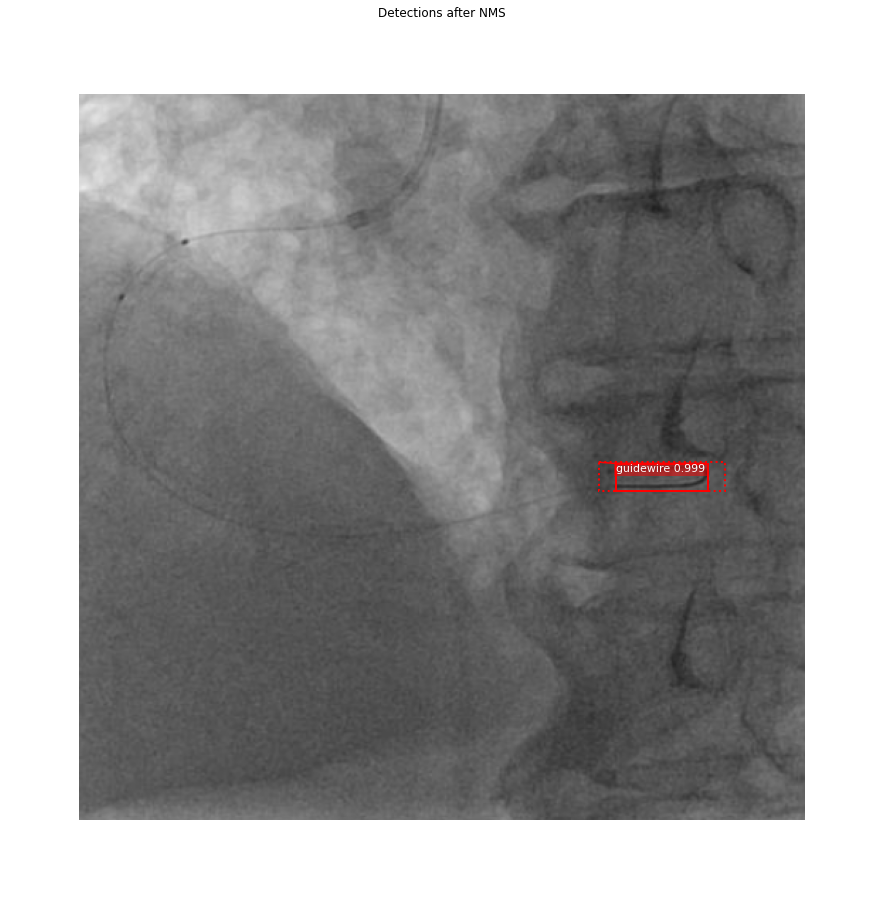

In [43]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.35425  max:    1.22900  float32
0.12325334548950195


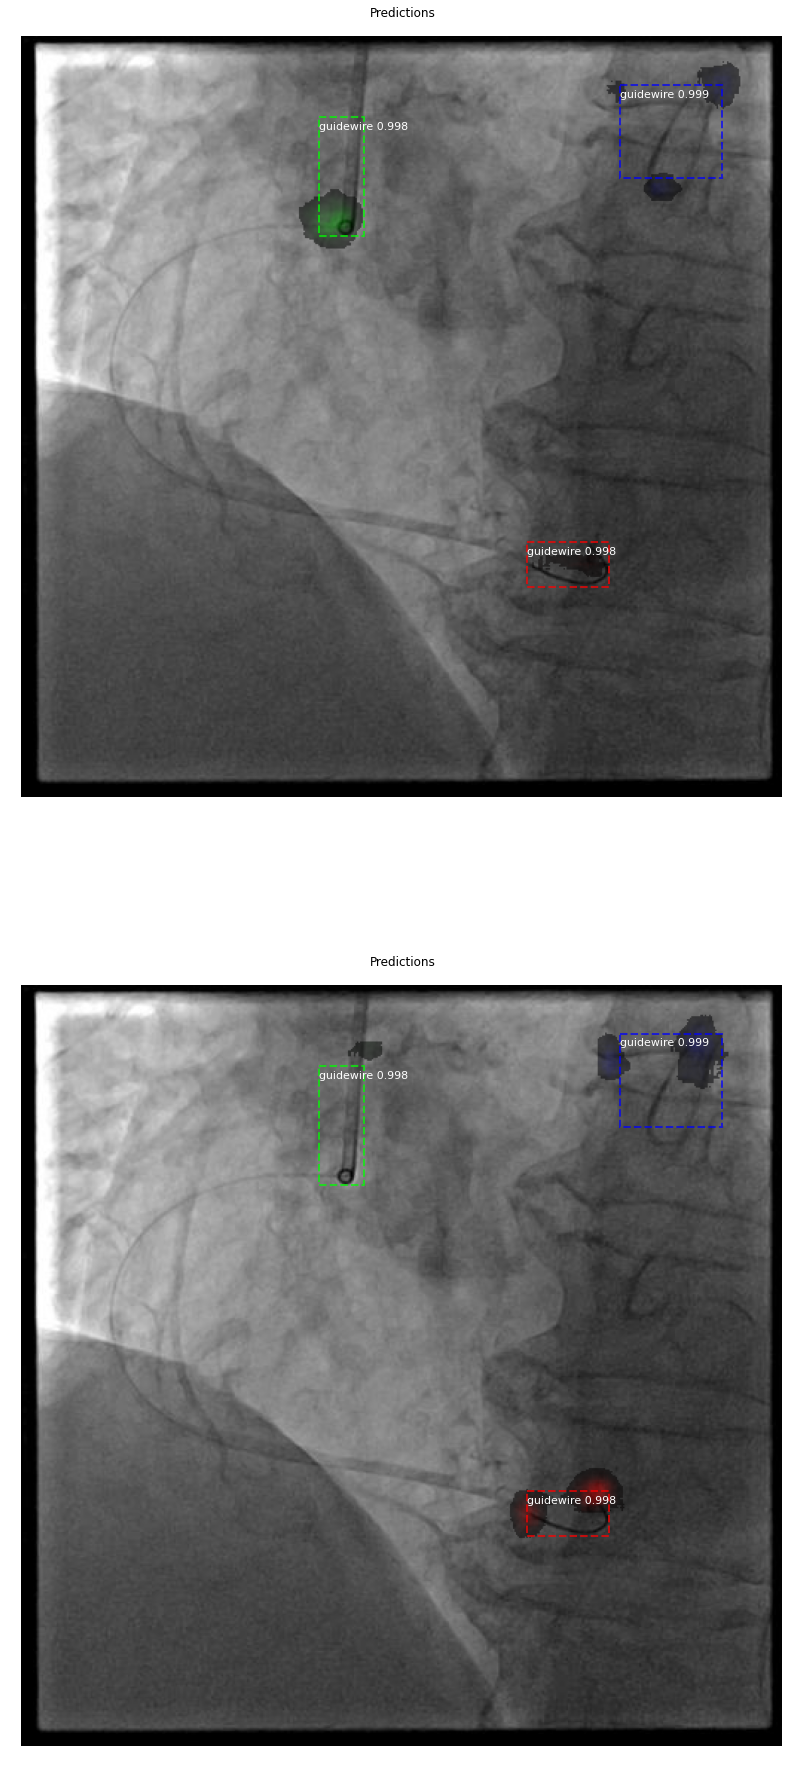

In [30]:
# image_id = random.choice(dataset.image_ids)
import time
image_id = 273
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

# Run object detection
s=time.time()
results = model.detect([image], verbose=1)
e=time.time()
print(e-s)
# Display results
ax = get_ax(2,1)
r = results[0]
visualize.display_point_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

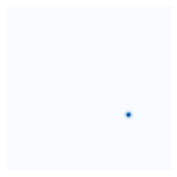

In [31]:
# display_images(image)
display_images(np.transpose(gt_mask, [2, 0, 1, 3])[:,:,:,0], cmap="Blues")

### 3.b Predicted Masks

In [32]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),

])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
print(det_class_ids)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 5, 6)             min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 5, 64, 64, 2)     min:    0.00000  max:    0.82004  float32
[1 1 1 0 0]
3 detections: ['guidewire' 'guidewire' 'guidewire']


In [33]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, :] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_point_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (3, 64, 64, 2)        min:    0.00000  max:    0.82004  float32
det_masks                shape: (3, 512, 512, 2)      min:    0.00000  max:    0.81342  float32


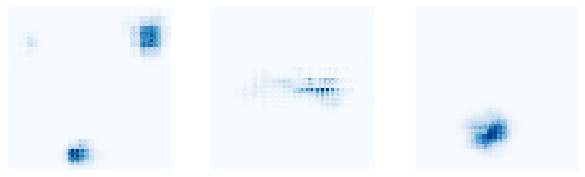

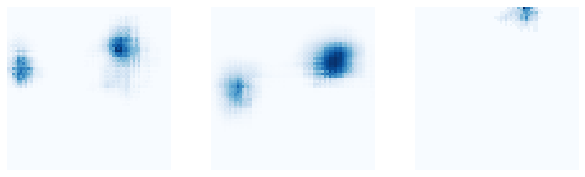

In [34]:
display_images(det_mask_specific[:,:,:,0] * 255, cmap="Blues", interpolation="none")
display_images(det_mask_specific[:,:,:,1] * 255, cmap="Blues", interpolation="none")

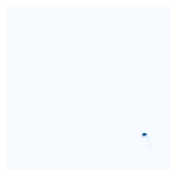

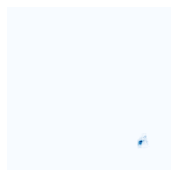

In [29]:
display_images(det_masks[:,:,:,0] * 255, cmap="Blues", interpolation="none")
display_images(det_masks[:,:,:,1] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [83]:

activations1 = model.run_graph_train([image], [
     ('gt',model.keras_model.get_layer("rpn_class_loss").output)
])

ValueError: No such layer: rpn_class_loss

In [10]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
#     ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

False
[<tf.Tensor 'input_image:0' shape=(?, ?, ?, 3) dtype=float32>, <tf.Tensor 'input_image_meta:0' shape=(?, 14) dtype=float32>, <tf.Tensor 'input_anchors:0' shape=(?, ?, 4) dtype=float32>]
input_image              shape: (1, 512, 512, 3)      min: -123.70000  max:   82.10000  float32
res2c_out                shape: (1, 128, 128, 256)    min:    0.00000  max:   35.24088  float32
res3c_out                shape: (1, 64, 64, 512)      min:    0.00000  max:   21.89959  float32
rpn_bbox                 shape: (1, 65472, 4)         min:   -6.22745  max:   20.87972  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


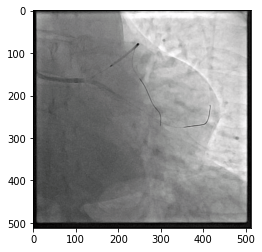

In [17]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

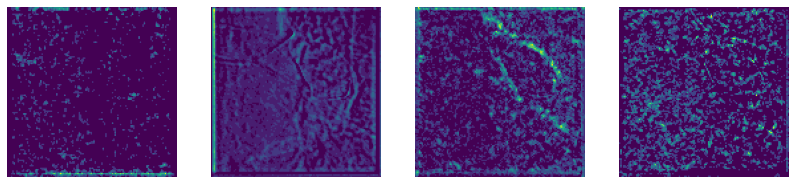

In [18]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)